In [1]:
%load_ext autoreload
%autoreload 2
import glob, sys
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import simps
import pyccl as ccl
import clmm
from clmm import Cosmology
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

In [2]:
clmm.__version__

'1.10.0'

In [3]:
%load_ext autoreload
%autoreload 2
sys.path.append('../../modeling/')
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_COUNT_modeling_richness_mass_relation as rm_relation
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_cluster_abundance as cl_count
import CL_LENSING_cluster_lensing as cl_lensing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hyper-parameters
## Hyper-parameters (non-cosmo)

In [4]:
#cosmology
Omega_m_true = 0.265
Omega_b_true = 0.048254
sigma8_true = .8288


## Hyper-parameters (non-cosmo)

In [5]:
#purity
a_nc, b_nc, a_rc, b_rc = np.log(10)*0.8612, np.log(10)*0.3527, 2.2183, -0.6592
theta_purity = [a_nc, b_nc, a_rc, b_rc]
#completeness
a_nc, b_nc, a_mc, b_mc = 1.1321, 0.7751, 13.31, 0.2025
theta_completeness = [a_nc, b_nc, a_mc, b_mc]
#rm_relation
log10m0, z0 = np.log10(10**14.3), .5
proxy_mu0, proxy_muz, proxy_mulog10m =  3.091, 0, 1.05*np.log(10)
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  0.594, 0., 0.026*np.log(10)
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]

# Purity

In [6]:
richness_grid = np.logspace(np.log10(2), np.log10(500), 310)
logm_grid = np.linspace(12, 15., 50)
z_grid = np.linspace(.1, 1, 11)

In [7]:
np.log10(2*1e15)

15.301029995663981

# Cluster Abundance

In [8]:
z_edges = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1])
Z_bin = binning(z_edges)
richness_edges = np.array([20, 35, 70, 100, 200])
Richness_bin = binning(richness_edges)

## effect of purity and completeness

In [9]:
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
adds_N = {'add_purity' : True, 'add_completeness':True}
adds_DS = {'add_purity' : True, 'add_completeness':True}
bins = {'redshift_bins':Z_bin, 'richness_bins': Richness_bin}
compute = {'compute_dNdzdlogMdOmega_log_slope':True,
           'compute_dNdzdlogMdOmega':True,'compute_richness_mass_relation':True, 
           'compute_completeness':True, 'compute_halo_bias':True ,'compute_purity':True }

In [10]:
def cluster_lensing_kernel(cosmo_ccls, grids):
    r = np.logspace(np.log10(.01), np.log10(20),30)
    cosmo_clmms = cosmo_clmm_fid
    cosmo_clmms.be_cosmo = cosmo_ccls
    cluster_lensing_1h_individual = cl_lensing.compute_cluster_lensing(r, 'Duffy08', grids['logm_grid'], grids['z_grid'], cosmo_ccls, cosmo_clmms)
    return r, cluster_lensing_1h_individual

In [11]:
def integrand_count_prediction(cosmo_cclw, grids):
    massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
    hmd = ccl.halos.hmfunc.MassFuncDespali16(mass_def=massdef)
    count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
    params = {'params_purity':theta_purity, 'params_completeness': theta_completeness, 'params_richness_mass_relation': theta_rm,
             'CCL_cosmology': cosmo_cclw, 'halo_mass_distribution': hmd, 'params_concentration_mass_relation': 'Duffy08'}
    count_modelling_new = cl_count.recompute_count_modelling(count_modelling, 
                                                             grids = grids, compute = compute, 
                                                             params = params)
    integrand_count_N = cl_count.define_count_integrand(count_modelling_new, adds_N)
    integrand_count_DS = cl_count.define_count_integrand(count_modelling_new, adds_DS)
    return integrand_count_N, integrand_count_DS

In [12]:
def compute_stack(r, cluster_lensing_kernel, N_kernel, DS_kernel, grids):

    Omega = (4*np.pi)
    N = Omega * cl_count.Cluster_SurfaceDensity_ProxyZ(bins, integrand_count = N_kernel, grids = grids)
    
    NDS_profiles = Omega * cl_lensing.Cluster_dNd0mega_Lensing_ProxyZ(bins, integrand_count = DS_kernel, 
                                                                      cluster_lensing = cluster_lensing_kernel, 
                                                                      lensing_radius = r, grids = grids)
    DS_profiles = NDS_profiles/N
    return N, DS_profiles

In [13]:
def cluster_obs(cosmo_ccl, grids):
    r, cluster_lensing_1h_individual = cluster_lensing_kernel(cosmo_ccl, grids)
    integrand_count_N, integrand_count_DS = integrand_count_prediction(cosmo_ccl, grids)
    N, DS_profiles = compute_stack(r, cluster_lensing_1h_individual, integrand_count_N, integrand_count_DS, grids)
    return r, N, DS_profiles

In [16]:
grids_resol = {'logm_grid': np.linspace(12, 15.5, 150), 
               'z_grid': np.linspace(.2, 1, 150), 
               'richness_grid':np.logspace(np.log10(20), np.log10(200), 150)}
r, N_resol, DS_profiles_resol = cluster_obs(cosmo_ccl, grids_resol)

NameError: name 'cosmo_clmm_fid' is not defined

In [103]:
grids_low = {'logm_grid': np.linspace(12, 15., 50), 
               'z_grid': np.linspace(.2, 1, 50), 
               'richness_grid':np.logspace(np.log10(20), np.log10(200), 100)}
r, N_low, DS_profiles_low = cluster_obs(cosmo_ccl, grids_low)

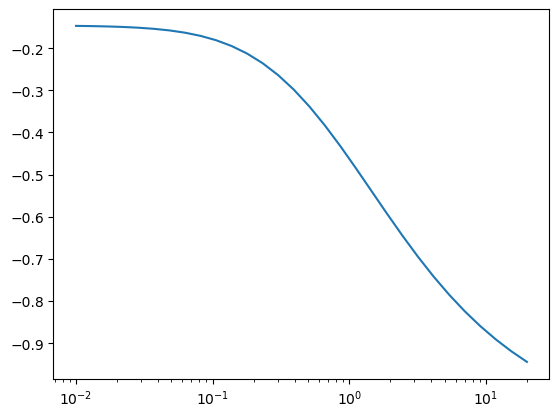

In [108]:
plt.plot(r, 100*(DS_profiles_low[:,2,2]/DS_profiles_resol[:,2,2]-1))
plt.xscale('log')

In [47]:
cosmo_clmm_fid = Cosmology(H0 = 71.0, Omega_dm0 = Omega_m_true - Omega_b_true, Omega_b0 = Omega_b_true, Omega_k0 = 0.0)
cosmo_ccl_fid = ccl.Cosmology(Omega_c = Omega_m_true - Omega_b_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
r, lensing_kernel_fid = cluster_lensing_kernel(cosmo_ccl_fid, grids)
integrand_count_N_fid, integrand_count_DS_fid = integrand_count_prediction(cosmo_ccl_fid, grids)
N_fid, DS_profiles_fid = compute_stack(r, lensing_kernel_fid, integrand_count_N_fid, integrand_count_DS_fid, grids)

In [15]:
cosmo_ccl = ccl.Cosmology(Omega_c = 0.2 - Omega_b_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96, w0=-2.5)
rho_crit_fid = cosmo_ccl_fid.rho_x(1/(1+z_grid), 'critical',) 
rho_crit = cosmo_ccl.rho_x(1/(1+z_grid), 'critical',) 
ratio = rho_crit/rho_crit_fid

ratio_mat = np.zeros(lensing_kernel_fid.shape)
for i in range(len(ratio_mat[:,0,0])):
    for j in range(len(ratio_mat[0,:,0])):
        ratio_mat[i,j,:] = ratio


r, lensing_kernel = cluster_lensing_kernel(cosmo_ccl, grids)
integrand_count_N, integrand_count_DS = integrand_count_prediction(cosmo_ccl, grids)

N_fid, DS_profiles_wrong = compute_stack(r, lensing_kernel_fid, integrand_count_N, integrand_count_DS, grids)

lensing_kernel_fid_corr = lensing_kernel_fid * ratio_mat

N_fid, DS_profiles_wrong_and_correct = compute_stack(r, lensing_kernel_fid_corr, integrand_count_N, integrand_count_DS, grids)

N_fid, DS_profiles_true = compute_stack(r, lensing_kernel, integrand_count_N, integrand_count_DS, grids)

NameError: name 'cosmo_ccl_fid' is not defined

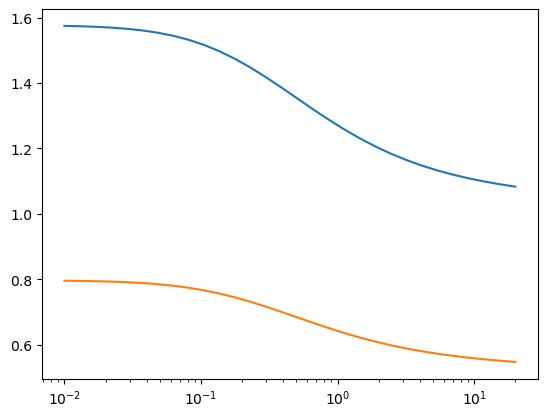

In [55]:
plt.plot(r, DS_profiles_wrong[:,1,0]/ DS_profiles_true[:,1,0])
plt.plot(r, DS_profiles_wrong_and_correct[:,1,0]/ DS_profiles_true[:,1,0])
plt.xscale('log')